# ClinicalNotes task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from clinical_notes import ClinicalNotes
from dataset_generator import DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Error test (low complexity)

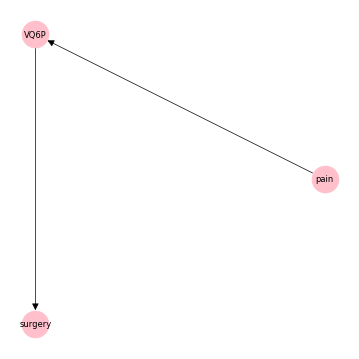


Context: Chronic disease IYSKBI sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele D4LZ, a genetic marker for severe IYSKBI. If the patient self-reports significant pain or the patient has a family history of QZFE, then vital VQ6P will be elevated (greater than 1.21 mg/dL). If VQ6P is elevated and the patient has a family history of 7BXO, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Dawn Webb. History of Present Illness: Dawn Webb is a 65-year-old female with IYSKBI who presented to the emergency department with acute onset pain that began 5 hours prior to arrival. Pain was rated 3/10. The patient reports the pain has been persistent since onset. The patient took aspirin (10

In [3]:
size = [2,2]
tg = ClinicalNotes(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_sample_context(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

In [4]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0, 'VQ6P': 0, 'surgery': 0},
  'True exogenous': {'D4LZ': 0, 'QZFE': 0, '7BXO': 0},
  'True response': 0},
 'VQ6P': {'Prompt': 'Given these history and physical notes, will vital VQ6P be elevated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0, 'VQ6P': 0, 'surgery': 0},
  'True exogenous': {'D4LZ': 0, 'QZFE': 0, '7BXO': 0},
  'True response': 0}}

In [5]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'VQ6P': 1, 'surgery': 0}
True exogenous: {'D4LZ': 0, 'QZFE': 0, '7BXO': 0}
True response: 0

-----------------------

-- ('pain', 'VQ6P') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will vital VQ6P be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'VQ6P': 1, 'surgery': 0}
True exogenous: {'D4LZ': 0, 'QZFE': 0, '7BXO': 0}
True response: 1

-----------------------

-- ('VQ6P', 'surgery') --
Prompt: Now suppose that vital VQ6P will be elevated regardless of all other circumstances. With this new a

In [6]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'VQ6P': 0, 'surgery': 0}
True exogenous: {'D4LZ': 0, 'QZFE': 0, '7BXO': 0}
True response: 0

-----------------------

-- ('pain', 'VQ6P') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will vital VQ6P be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'VQ6P': 0, 'surgery': 0}
True exogenous: {'D4LZ': 0, 'QZFE': 0, '7BXO': 0}
True response: 0

-----------------------

-- ('VQ6P', 'surgery') --
Prompt: Now suppose that vital VQ6P will not be elevated regardless of all other circumstances. With this new assumption, 

In [7]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,VQ6P,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,D4LZ,QZFE,7BXO
0,1,0,0
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1


In [8]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- VQ6P = 1 --


,pain,VQ6P,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,D4LZ,QZFE,7BXO
0,1,0,0
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1



-- pain = 1 --


,pain,VQ6P,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,D4LZ,QZFE,7BXO
0,1,0,0
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1


In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- VQ6P = 0 --


,pain,VQ6P,surgery
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


,D4LZ,QZFE,7BXO
0,1,0,0
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1



-- pain = 0 --


,pain,VQ6P,surgery
0,0,0,0
1,0,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,D4LZ,QZFE,7BXO
0,1,0,0
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1


## Error test (moderate complexity)

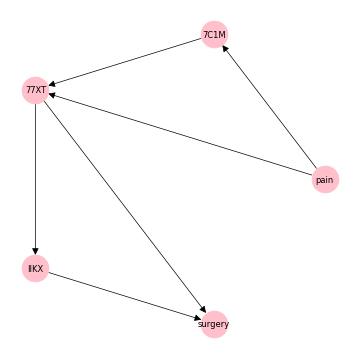


Context: Chronic disease GGRC88 sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 8/10) if they carry allele L626, a genetic marker for severe GGRC88. If the patient self-reports significant pain or the patient carries allele TEO6, then lab 7C1M will be elevated (greater than 2.39 mg/dL). If the patient self-reports significant pain or 7C1M is elevated or the patient has previously received surgery for ZSEO, then lab 77XT will be low (less than 2.62 mg/dL). If 77XT is low or the patient has a family history of V10L, then lab IIKX will be low (less than 2.46 mg/dL). If 77XT is low and IIKX is low and the patient carries allele TVWR, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Curtis Griffin. History 

In [10]:
size = [3,3]
tg = ClinicalNotes(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_sample_context(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

In [11]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1,
   '7C1M': 1,
   '77XT': 1,
   'IIKX': 1,
   'surgery': 0},
  'True exogenous': {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0},
  'True response': 0},
 '77XT': {'Prompt': 'Given these history and physical notes, will lab 77XT be low? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 1,
   '7C1M': 1,
   '77XT': 1,
   'IIKX': 1,
   'surgery': 0},
  'True exogenous': {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0},
  'True response': 1}}

In [12]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '7C1M': 1, '77XT': 1, 'IIKX': 1, 'surgery': 0}
True exogenous: {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0}
True response: 0

-----------------------

-- ('pain', '77XT') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will lab 77XT be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '7C1M': 1, '77XT': 1, 'IIKX': 1, 'surgery': 0}
True exogenous: {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0}
True response: 1

-----------------------

-- ('77XT', 'surgery') --
Prompt: Now suppose that l

In [13]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '7C1M': 0, '77XT': 1, 'IIKX': 1, 'surgery': 0}
True exogenous: {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0}
True response: 0

-----------------------

-- ('pain', '77XT') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will lab 77XT be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '7C1M': 0, '77XT': 1, 'IIKX': 1, 'surgery': 0}
True exogenous: {'L626': 1, 'TEO6': 0, 'ZSEO': 1, 'V10L': 0, 'TVWR': 0}
True response: 1

-----------------------

-- ('77XT', 'surgery') --
Prompt: Now suppose that lab 77XT will no

In [14]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,7C1M,77XT,IIKX,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,0,1,0
4,0,0,1,1,0


,L626,TEO6,ZSEO,V10L,TVWR
0,1,0,1,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,0,1,0
4,0,0,1,1,0


In [15]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- 77XT = 1 --


,pain,7C1M,77XT,IIKX,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,L626,TEO6,ZSEO,V10L,TVWR
0,1,0,1,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,0,1,0
4,0,0,1,1,0



-- pain = 1 --


,pain,7C1M,77XT,IIKX,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,1
3,1,1,1,1,0
4,1,1,1,1,0


,L626,TEO6,ZSEO,V10L,TVWR
0,1,0,1,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,0,1,0
4,0,0,1,1,0


In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- 77XT = 0 --


,pain,7C1M,77XT,IIKX,surgery
0,1,1,0,1,0
1,1,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0


,L626,TEO6,ZSEO,V10L,TVWR
0,1,0,1,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,0,1,0
4,0,0,1,1,0



-- pain = 0 --


,pain,7C1M,77XT,IIKX,surgery
0,0,0,1,1,0
1,0,1,1,1,0
2,0,1,1,1,1
3,0,0,0,1,0
4,0,0,1,1,0


,L626,TEO6,ZSEO,V10L,TVWR
0,1,0,1,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,0,1,0
4,0,0,1,1,0


In [17]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('pain', 'surgery')]
[('pain', '77XT'), ('77XT', 'surgery')]
[[('pain', '77XT'), ('77XT', 'surgery')]]


In [18]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = dg.get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5 --
-- PNS = 0.0 | ATE = 0.0 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,1



-- ('pain', '77XT') | n = 5 --
-- PNS = 0.2 | ATE = 0.19999999999999996 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,0,1,1,0,0



-- ('77XT', 'surgery') | n = 5 --
-- PNS = 0.2 | ATE = 0.2 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 10 --
-- PNS = 0.0 | ATE = 0.0 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', '77XT') | n = 10 --
-- PNS = 0.0 | ATE = 0.0 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,1,0
4,0,1,1,1,1,0



-- ('77XT', 'surgery') | n = 10 --
-- PNS = 0.6 | ATE = 0.6 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,1,1,1,1,0,0
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 50 --
-- PNS = 0.08 | ATE = 0.08000000000000002 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,0
2,1,1,1,1,0,0
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', '77XT') | n = 50 --
-- PNS = 0.16 | ATE = 0.16000000000000003 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,0,1,1,0,0
3,0,1,1,1,0,0
4,0,0,1,1,1,0



-- ('77XT', 'surgery') | n = 50 --
-- PNS = 0.52 | ATE = 0.52 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 100 --
-- PNS = 0.06 | ATE = 0.06 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', '77XT') | n = 100 --
-- PNS = 0.08 | ATE = 0.07999999999999996 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,1,0



-- ('77XT', 'surgery') | n = 100 --
-- PNS = 0.51 | ATE = 0.51 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 500 --
-- PNS = 0.074 | ATE = 0.07400000000000001 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', '77XT') | n = 500 --
-- PNS = 0.132 | ATE = 0.132 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,0,1,1,1,0
3,0,0,1,1,0,0
4,0,1,1,1,1,0



-- ('77XT', 'surgery') | n = 500 --
-- PNS = 0.512 | ATE = 0.512 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,1
2,1,1,1,1,0,0
3,1,1,1,1,1,1
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 1000 --
-- PNS = 0.064 | ATE = 0.064 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,1
2,1,1,1,1,0,0
3,1,1,1,1,1,1
4,1,1,1,1,0,1



-- ('pain', '77XT') | n = 1000 --
-- PNS = 0.114 | ATE = 0.11399999999999999 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,0,1,1,0,0
3,0,0,1,1,1,0
4,0,1,1,1,0,0



-- ('77XT', 'surgery') | n = 1000 --
-- PNS = 0.492 | ATE = 0.492 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5000 --
-- PNS = 0.0572 | ATE = 0.05720000000000003 --


,pain,7C1M,True (cause = True),IIKX,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', '77XT') | n = 5000 --
-- PNS = 0.1146 | ATE = 0.11460000000000004 --


,pain,7C1M,77XT,IIKX,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,0,1,1,1,0
3,0,0,1,1,0,0
4,0,1,1,1,0,0



-- ('77XT', 'surgery') | n = 5000 --
-- PNS = 0.4914 | ATE = 0.4914 --


In [19]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.0
Composition = 0.04000000000000001

-- n = 10 --
Global PNS  = 0.0
Composition = 0.0

-- n = 50 --
Global PNS  = 0.08
Composition = 0.08320000000000001

-- n = 100 --
Global PNS  = 0.06
Composition = 0.0408

-- n = 500 --
Global PNS  = 0.074
Composition = 0.067584

-- n = 1000 --
Global PNS  = 0.064
Composition = 0.056088

-- n = 5000 --
Global PNS  = 0.0572
Composition = 0.05631444


In [20]:
results_dict

{5: {('pain', 'surgery'): 0.0,
  ('pain', '77XT'): 0.2,
  ('77XT', 'surgery'): 0.2},
 10: {('pain', 'surgery'): 0.0,
  ('pain', '77XT'): 0.0,
  ('77XT', 'surgery'): 0.6},
 50: {('pain', 'surgery'): 0.08,
  ('pain', '77XT'): 0.16,
  ('77XT', 'surgery'): 0.52},
 100: {('pain', 'surgery'): 0.06,
  ('pain', '77XT'): 0.08,
  ('77XT', 'surgery'): 0.51},
 500: {('pain', 'surgery'): 0.074,
  ('pain', '77XT'): 0.132,
  ('77XT', 'surgery'): 0.512},
 1000: {('pain', 'surgery'): 0.064,
  ('pain', '77XT'): 0.114,
  ('77XT', 'surgery'): 0.492},
 5000: {('pain', 'surgery'): 0.0572,
  ('pain', '77XT'): 0.1146,
  ('77XT', 'surgery'): 0.4914}}

## Error test (high complexity)

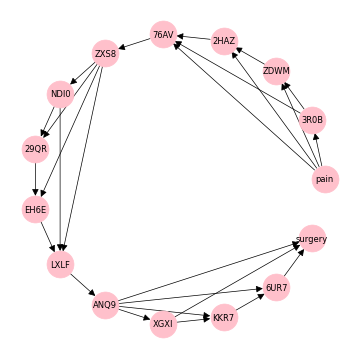


Context: Chronic disease HP0AHF sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele JQLC, a genetic marker for severe HP0AHF. If the patient self-reports significant pain or the patient has a family history of T20Z, then vital 3R0B will be low (less than 0.3 mg/dL). If the patient self-reports significant pain or 3R0B is low or the patient has a family history of FIYO, then lab ZDWM will be elevated (greater than 1.0 mg/dL). If the patient self-reports significant pain or ZDWM is elevated or the patient has a family history of 2UGQ, then vital 2HAZ will be low (less than 0.15 mg/dL). If the patient self-reports significant pain or 3R0B is low or 2HAZ is low or the patient carries allele IC4D, then lab 76AV will be low (less than 2.93 mg/dL). If 76AV is low or the patient carries allele 69B6, then vital ZXS8 will be low (les

In [34]:
size = [5,2,5,2,5]
tg = ClinicalNotes(n_per_bcc = size, 
                   bcc_types = ["wheel"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_sample_context(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

In [22]:
print(tg.exog_names)
print(tg.exog_true_binary)
print(tg.alleles_obs)
print(tg.fam_hist_obs)
print(tg.prev_surg_obs)

['V864', '3YKF', '1KSR', 'U1TZ', 'NRYM', '2N87', 'VONE', 'YOLL', 'H7MU', '06OA', 'XN3M', 'IM3H', 'K1DX']
[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]
['V864', '2N87', 'VONE', 'XN3M']
['YOLL']
['1KSR']


## Generate dataset

In [23]:
# x levels of graphical complexity (captured by BCC size).
# y tasks per graphical complexity level.
# z samples per task.
# w replicates per sample.
# = x*y*z*w subtasks.
graph_sizes = [[2,2],[3,3],[4,4]]
n_tasks_per_size = 3
n_samples_per_task = 1000
reps_per_sample = 5

df = dg.get_dataset(task_generator = ClinicalNotes,
                    graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task, 
                    reps_per_sample = reps_per_sample)

display(df)

,Task ID,Context ID,Sample ID,Nodes per BCC,Replicate ID,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Exogenous variables,Bernoulli parameters,Global quantity,Local quantities,Compositions,Causal context,Sample context,Factual queries,Interventional queries (cause = True),Interventional queries (cause = False)
0,0.0.0,0,0,"[2, 2]",0,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[ZNRU, H1G0, DWEJ]","[0.6, 0.5, 0.7]","(pain, surgery)","[(pain, QVN0), (QVN0, surgery)]","[[(pain, QVN0), (QVN0, surgery)]]",Chronic disease 8F3I7Q sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.0.1,0,0,"[2, 2]",1,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[ZNRU, H1G0, DWEJ]","[0.6, 0.5, 0.7]","(pain, surgery)","[(pain, QVN0), (QVN0, surgery)]","[[(pain, QVN0), (QVN0, surgery)]]",Chronic disease 8F3I7Q sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.0.2,0,0,"[2, 2]",2,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[ZNRU, H1G0, DWEJ]","[0.6, 0.5, 0.7]","(pain, surgery)","[(pain, QVN0), (QVN0, surgery)]","[[(pain, QVN0), (QVN0, surgery)]]",Chronic disease 8F3I7Q sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.0.3,0,0,"[2, 2]",3,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[ZNRU, H1G0, DWEJ]","[0.6, 0.5, 0.7]","(pain, surgery)","[(pain, QVN0), (QVN0, surgery)]","[[(pain, QVN0), (QVN0, surgery)]]",Chronic disease 8F3I7Q sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.0.4,0,0,"[2, 2]",4,"[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, QVN0, surgery]","[ZNRU, H1G0, DWEJ]","[0.6, 0.5, 0.7]","(pain, surgery)","[(pain, QVN0), (QVN0, surgery)]","[[(pain, QVN0), (QVN0, surgery)]]",Chronic disease 8F3I7Q sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,8.999.0,8,999,"[4, 4]",0,"[[0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, AFBC, PCIV, FM6H, F7MK, DXF1, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, FM6H, surgery]","[17RA, GAE0, MF03, L05G, KEZQ, AKBE, J3UQ]","[0.4, 0.5, 0.4, 0.4, 0.7, 0.8, 0.6]","(pain, surgery)","[(pain, FM6H), (FM6H, surgery)]","[[(pain, FM6H), (FM6H, surgery)]]",Chronic disease 620X9A sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
44996,8.999.1,8,999,"[4, 4]",1,"[[0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, AFBC, PCIV, FM6H, F7MK, DXF1, surgery]","[[0, 1, 1], [0, 0, 1], [0, 0, 0]]","[pain, FM6H, surgery]","[17RA, GAE0, MF03, L05G, KEZQ, AKBE, J3UQ]","[0.4, 0.5, 0.4, 0.4, 0.7, 0.8, 0.6]","(pain, surgery)","[(pain, FM6H), (FM6H, surgery)]","[[(pain, FM6H), 

In [24]:
# Process prompts.
df_factual, df_cf = dg.process_prompts()
display(df_factual)
display(df_cf)

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Effect,Context,Question,True
0,0.0.0,0,0,0,"[2, 2]",surgery,Chronic disease 8F3I7Q sometimes requires surg...,"Given these history and physical notes, will t...",0
1,0.0.0,0,0,0,"[2, 2]",QVN0,Chronic disease 8F3I7Q sometimes requires surg...,"Given these history and physical notes, will l...",1
2,0.0.1,0,0,1,"[2, 2]",surgery,Chronic disease 8F3I7Q sometimes requires surg...,"Given these history and physical notes, will t...",0
3,0.0.1,0,0,1,"[2, 2]",QVN0,Chronic disease 8F3I7Q sometimes requires surg...,"Given these history and physical notes, will l...",1
4,0.0.2,0,0,2,"[2, 2]",surgery,Chronic disease 8F3I7Q sometimes requires surg...,"Given these history and physical notes, will t...",0
...,...,...,...,...,...,...,...,...,...
89995,8.999.2,8,999,2,"[4, 4]",FM6H,Chronic disease 620X9A sometimes requires surg...,"Given these history and physical notes, will v...",0
89996,8.999.3,8,999,3,"[4, 4]",surgery,Chronic disease 620X9A sometimes requires surg...,"Given these history and physical notes, will t...",0
89997,8.999.3,8,999,3,"[4, 4]",FM6H,Chronic disease 620X9A sometimes requires surg...,"Given these history and physical notes, will v...",0
89998,8.999.4,8,999,4,"[4, 4]",surgery,Chronic disease 620X9A sometimes requires surg...,"Given these history and physical notes, will t...",0


,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
0,0.0.0,0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
1,0.0.0,0,0,0,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,1
2,0.0.0,0,0,0,"[2, 2]","(QVN0, surgery)",QVN0,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that lab QVN0 will be elevated reg...,0,Now suppose that lab QVN0 will not be elevated...,0
3,0.0.1,0,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
4,0.0.1,0,0,1,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,8.999.3,8,999,3,"[4, 4]","(pain, FM6H)",pain,FM6H,Chronic disease 620X9A sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
134996,8.999.3,8,999,3,"[4, 4]","(FM6H, surgery)",FM6H,surgery,Chronic disease 620X9A sometimes requires surg...,Now suppose that vital FM6H will be elevated r...,0,Now suppose that vital FM6H will not be elevat...,0
134997,8.999.4,8,999,4,"[4, 4]","(pain, surgery)",pain,surgery,Chronic disease 620X9A sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
134998,8.999.4,8,999,4,"[4, 4]","(pain, FM6H)",pain,FM6H,Chronic disease 620X9A sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0


In [25]:
pns_dict = dg.get_pns_dict(verbose = True)
pns_dict

-- PNS = 0.352 | ATE = 0.352 --
-- PNS = 0.519 | ATE = 0.519 --
-- PNS = 0.697 | ATE = 0.697 --
-- PNS = 0.131 | ATE = 0.131 --
-- PNS = 0.31 | ATE = 0.31000000000000005 --
-- PNS = 0.382 | ATE = 0.382 --
-- PNS = 0.238 | ATE = 0.238 --
-- PNS = 0.397 | ATE = 0.397 --
-- PNS = 0.592 | ATE = 0.592 --
-- PNS = 0.03 | ATE = 0.030000000000000027 --
-- PNS = 0.052 | ATE = 0.052000000000000046 --
-- PNS = 0.511 | ATE = 0.511 --
-- PNS = 0.051 | ATE = 0.051000000000000045 --
-- PNS = 0.06 | ATE = 0.06000000000000005 --
-- PNS = 0.801 | ATE = 0.801 --
-- PNS = 0.12 | ATE = 0.12 --
-- PNS = 0.201 | ATE = 0.20099999999999996 --
-- PNS = 0.598 | ATE = 0.598 --
-- PNS = 0.036 | ATE = 0.03599999999999992 --
-- PNS = 0.058 | ATE = 0.05800000000000005 --
-- PNS = 0.709 | ATE = 0.709 --
-- PNS = 0.048 | ATE = 0.04799999999999993 --
-- PNS = 0.081 | ATE = 0.08099999999999996 --
-- PNS = 0.586 | ATE = 0.586 --
-- PNS = 0.099 | ATE = 0.09899999999999998 --
-- PNS = 0.161 | ATE = 0.16100000000000003 --
--

{0: {"('pain', 'surgery')": 0.352,
  "('pain', 'QVN0')": 0.519,
  "('QVN0', 'surgery')": 0.697,
  "[('pain', 'QVN0'), ('QVN0', 'surgery')]": 0.361743},
 1: {"('pain', 'surgery')": 0.131,
  "('pain', 'AGJF')": 0.31,
  "('AGJF', 'surgery')": 0.382,
  "[('pain', 'AGJF'), ('AGJF', 'surgery')]": 0.11842},
 2: {"('pain', 'surgery')": 0.238,
  "('pain', 'WW0E')": 0.397,
  "('WW0E', 'surgery')": 0.592,
  "[('pain', 'WW0E'), ('WW0E', 'surgery')]": 0.235024},
 3: {"('pain', 'surgery')": 0.03,
  "('pain', 'JQ07')": 0.052,
  "('JQ07', 'surgery')": 0.511,
  "[('pain', 'JQ07'), ('JQ07', 'surgery')]": 0.026572},
 4: {"('pain', 'surgery')": 0.051,
  "('pain', '8UYC')": 0.06,
  "('8UYC', 'surgery')": 0.801,
  "[('pain', '8UYC'), ('8UYC', 'surgery')]": 0.04806},
 5: {"('pain', 'surgery')": 0.12,
  "('pain', 'PQJ0')": 0.201,
  "('PQJ0', 'surgery')": 0.598,
  "[('pain', 'PQJ0'), ('PQJ0', 'surgery')]": 0.120198},
 6: {"('pain', 'surgery')": 0.036,
  "('pain', 'EATT')": 0.058,
  "('EATT', 'surgery')": 0.709

In [26]:
threshold_dict = dg.get_internal_consistency_thresholds(multiplier = 1.25)
threshold_dict

{0: {"[('pain', 'QVN0'), ('QVN0', 'surgery')]": 0.0345987215909091},
 1: {"[('pain', 'AGJF'), ('AGJF', 'surgery')]": 0.12003816793893138},
 2: {"[('pain', 'WW0E'), ('WW0E', 'surgery')]": 0.015630252100840226},
 3: {"[('pain', 'JQ07'), ('JQ07', 'surgery')]": 0.14283333333333337},
 4: {"[('pain', '8UYC'), ('8UYC', 'surgery')]": 0.07205882352941172},
 5: {"[('pain', 'PQJ0'), ('PQJ0', 'surgery')]": 0.002062500000000039},
 6: {"[('pain', 'EATT'), ('EATT', 'surgery')]": 0.1778472222222223},
 7: {"[('pain', 'LQGN'), ('LQGN', 'surgery')]": 0.013906249999999993},
 8: {"[('pain', 'FM6H'), ('FM6H', 'surgery')]": 0.009974747474747463}}

In [27]:
# Test save and load with numpy.
np.save("clinical_notes_threshold_dict.npy", threshold_dict) 
read_dictionary = np.load("clinical_notes_threshold_dict.npy",
                          allow_pickle = "TRUE").item()
display(read_dictionary)

{0: {"[('pain', 'QVN0'), ('QVN0', 'surgery')]": 0.0345987215909091},
 1: {"[('pain', 'AGJF'), ('AGJF', 'surgery')]": 0.12003816793893138},
 2: {"[('pain', 'WW0E'), ('WW0E', 'surgery')]": 0.015630252100840226},
 3: {"[('pain', 'JQ07'), ('JQ07', 'surgery')]": 0.14283333333333337},
 4: {"[('pain', '8UYC'), ('8UYC', 'surgery')]": 0.07205882352941172},
 5: {"[('pain', 'PQJ0'), ('PQJ0', 'surgery')]": 0.002062500000000039},
 6: {"[('pain', 'EATT'), ('EATT', 'surgery')]": 0.1778472222222223},
 7: {"[('pain', 'LQGN'), ('LQGN', 'surgery')]": 0.013906249999999993},
 8: {"[('pain', 'FM6H'), ('FM6H', 'surgery')]": 0.009974747474747463}}

In [28]:
df_cf[df_cf["Context ID"] == 0]

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
0,0.0.0,0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
1,0.0.0,0,0,0,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,1
2,0.0.0,0,0,0,"[2, 2]","(QVN0, surgery)",QVN0,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that lab QVN0 will be elevated reg...,0,Now suppose that lab QVN0 will not be elevated...,0
3,0.0.1,0,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
4,0.0.1,0,0,1,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.999.3,0,999,3,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
14996,0.999.3,0,999,3,"[2, 2]","(QVN0, surgery)",QVN0,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that lab QVN0 will be elevated reg...,1,Now suppose that lab QVN0 will not be elevated...,0
14997,0.999.4,0,999,4,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
14998,0.999.4,0,999,4,"[2, 2]","(pain, QVN0)",pain,QVN0,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0


In [29]:
df_cf[(df_cf["Context ID"] == 0) & (df_cf["Cause-effect pair"] == ("pain", "surgery"))]

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
0,0.0.0,0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
3,0.0.1,0,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
6,0.0.2,0,0,2,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
9,0.0.3,0,0,3,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
12,0.0.4,0,0,4,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14985,0.999.0,0,999,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
14988,0.999.1,0,999,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
14991,0.999.2,0,999,2,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0
14994,0.999.3,0,999,3,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease 8F3I7Q sometimes requires surg...,Now suppose that the patient will be in signif...,1,Now suppose that the patient will not be in pa...,0


In [30]:
df_cf[(df_cf["Context ID"] == 1) & (df_cf["Cause-effect pair"] == ("pain", "surgery"))]

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
15000,1.0.0,1,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
15003,1.0.1,1,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
15006,1.0.2,1,0,2,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
15009,1.0.3,1,0,3,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
15012,1.0.4,1,0,4,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29985,1.999.0,1,999,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
29988,1.999.1,1,999,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
29991,1.999.2,1,999,2,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0
29994,1.999.3,1,999,3,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease NLH8SB sometimes requires surg...,Now suppose that the patient will be in signif...,0,Now suppose that the patient will not be in pa...,0


## End of document